# MNIST

In [1]:
import sys, warnings
# if sys.platform == 'linux':
#     sys.path.append("/home/yjg1005/nas/Python/Mega_IT")    
# else:
#     sys.path.append("Y:\Python\Mega_IT")
warnings.filterwarnings('ignore')

# from yjk_module.preprocessing import *
# from yjk_module.ml_module import *
# from yjk_module.dl_module import *

import os, sys
# if sys.platform == 'linux':
#     os.chdir("/home/yjg1005/nas/Python/Mega_IT/H.Deep_Learning")
# else:
#     os.chdir("Y:\Python\Mega_IT\H.Deep_Learning")

# from hossam.util import *
# from hossam.plot import *
# from hossam.tensor import *
# from hossam.classification import *

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D, BatchNormalization, Activation, ConvLSTM2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback, History
from keras.utils import to_categorical

from tensorflow.keras.datasets.mnist import load_data

2024-04-24 13:40:48.636258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 13:40:48.636284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 13:40:48.636907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 13:40:48.640510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 13:40:49.140184: W tensorflow/compiler/tf2

- CNN : 이미지를 분석하는데 사용되는 딥러닝 알고리즘 (RNN -> 텍스트)
- 합성곱 : 하나의 함수를 반전 및 전이 시킨 후 다른 함수와 곱한 결과를 적분
    - 필터 : 이미지의 특징을 찾는 공용 파라미터 (= 커널)
        - 필터는 (3, 3)등의 정사각 행렬로 정의됨
        - CNN은 필터를 학습함 (필터의 최적의 가중치를 찾는 과정)
    - 합성곱의 계산 : 필터가 지정된 간격(= strid)만큼 이동하면서 겹치는 부분끼리 합성곱을 실행하여 그 결과를 Feature Map으로 만듦
        - strid가 작을수록 필터가 더 촘촘히 이동하며 계산하므로 계산속도가 느려짐
        - 다수의 채널(ex. RGB)이 있을 경우 각각의 채널에 대하여 필터가 따로 존재하여 별개로 학습을 진행함
    - 패딩 : CNN의 특성상 Feature Map의 크기는 원본보다 작음. 이를 방지하기 위하여 입력 데이터의 외곽에 지정된 픽셀 크기만큼 특정 값(0)으로 감싸는 방법
    - 풀링 : 출력 데이터 (Feature Map)의 크기를 줄이는 용도, 일정 크기의 정사각 행렬을 이동시키며 최대값, 평균 등으로 값을 하나로 줄여서 데이터 크기를 감소시킴. CNN에서는 Max Pooling이 가장 많이 쓰임 (데이터의 특성을 가장 잘 보존함)

In [2]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = load_data(path="mnist.npz")

In [3]:
# 종속변수 OneHotEncoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
# 훈련 데이터 reshape
x_train_reshape = x_train.reshape(
    x_train.shape[0], x_train.shape[1], x_train.shape[2], 1
)
x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print(f"훈련 데이터 {x_train_reshape.shape} / 검증 데이터 {x_test_reshape.shape}")

훈련 데이터 (60000, 28, 28, 1) / 검증 데이터 (10000, 28, 28, 1)


- Activation : 단일 활성화 함수
- BatchNormalization : 표준화를 수행하는 층, 없다면 전처리는 직접 해줘야 할 필요가 있음. 반드시 Activation (혹은 다른 층의 activation) 이전에 진행되어야 함
- Dropout : 일부 뉴런을 off, 과적합 방지, 학습 속도도 약간 빨라질수 있음

In [5]:
# CNN 모델 구축
model = Sequential([
    Conv2D(64, activation = 'relu', kernel_size = (5, 5), padding = 'same', input_shape = (28, 28, 1), strides = (1, 1)),
    Dropout(0.1),
    MaxPool2D(2, strides = 1, padding = 'same'),
    Conv2D(32, activation = 'relu', kernel_size = (3, 3), padding = 'same', strides = 1),
    Dropout(0.1),
    MaxPool2D(2, strides = 1, padding = 'same'),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(10, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

2024-04-24 13:40:49.925217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22433 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


In [6]:
%%time
# 모델 훈련

history = model.fit(x_train_reshape, y_train_one_hot, validation_data = (x_test_reshape, y_test_one_hot), callbacks = [
    EarlyStopping(patience = 8, restore_best_weights = True)
], epochs = 1000, batch_size = 32)

Epoch 1/1000


2024-04-24 13:40:50.569720: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-24 13:40:50.630980: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-24 13:40:50.702334: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 13:40:50.845259: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 13:40:51.203479: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5e8dce4c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 13:40:51.203494: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 30

1875/1875 [==============================] - 7s 3ms/step - loss: 0.5722 - acc: 0.9093 - val_loss: 0.1128 - val_acc: 0.9671
Epoch 2/1000
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1534 - acc: 0.9561 - val_loss: 0.1017 - val_acc: 0.9690
Epoch 3/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1170 - acc: 0.9651 - val_loss: 0.0842 - val_acc: 0.9746
Epoch 4/1000
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1029 - acc: 0.9688 - val_loss: 0.0962 - val_acc: 0.9717
Epoch 5/1000
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0938 - acc: 0.9728 - val_loss: 0.0754 - val_acc: 0.9781
Epoch 6/1000
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0831 - acc: 0.9753 - val_loss: 0.0692 - val_acc: 0.9795
Epoch 7/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0717 - acc: 0.9781 - val_loss: 0.0698 - val_acc: 0.9795
Epoch 8/1000
1875/1875 [==============================] - 4s 

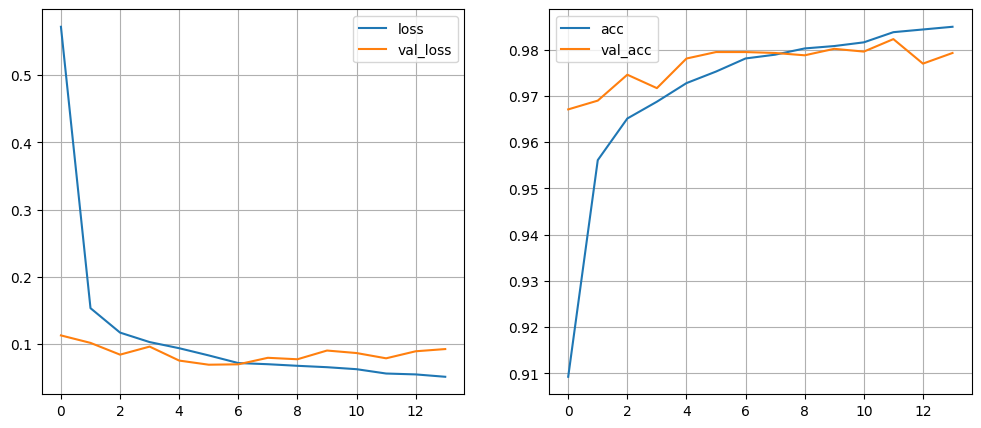

In [7]:
# 학습곡선 확인
# yjk_dl_history_plot(history, 'acc')

hist_dict = history.history
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].plot(hist_dict['loss'], label = 'loss')
ax[0].plot(hist_dict['val_loss'], label = 'val_loss')
ax[0].grid()
ax[0].legend()

ax[1].plot(hist_dict['acc'], label = 'acc')
ax[1].plot(hist_dict['val_acc'], label = 'val_acc')
ax[1].grid()
ax[1].legend()

plt.show()

In [8]:
# 검증 데이터 예측
pred = model.predict(x_test_reshape)
pred_2 = np.argmax(pred, axis = 1)

313/313 [==============================] - 0s 928us/step


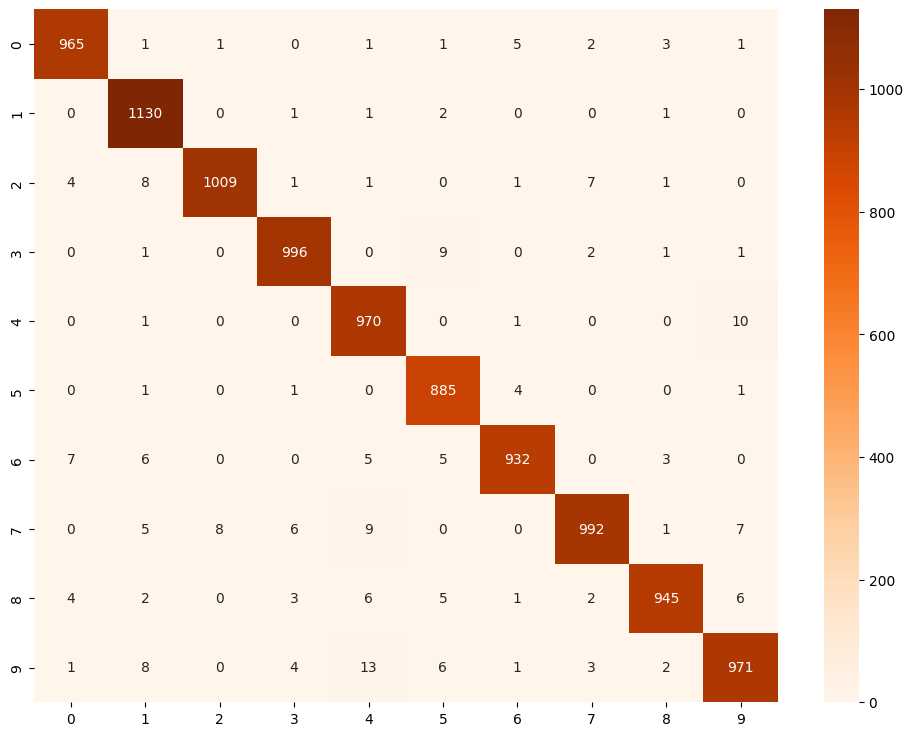

In [9]:
# 혼동행렬 출력
# my_confusion_matrix(y_test, pred_2, figsize = (14, 9))

c_mat = confusion_matrix(y_test, pred_2)

plt.figure(figsize = (12, 9))
sns.heatmap(c_mat, annot = True, fmt = 'd', cmap = 'Oranges')
plt.show()